<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-Data-Loading" data-toc-modified-id="Imports-and-Data-Loading-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and Data Loading</a></span><ul class="toc-item"><li><span><a href="#DataLoader-class" data-toc-modified-id="DataLoader-class-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><a href="https://pytorch.org/docs/stable/data.html" target="_blank">DataLoader class</a></a></span></li></ul></li><li><span><a href="#Building-a-Neural--Network" data-toc-modified-id="Building-a-Neural--Network-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Building a Neural  Network</a></span><ul class="toc-item"><li><span><a href="#Activation-Functions" data-toc-modified-id="Activation-Functions-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Activation Functions</a></span></li></ul></li><li><span><a href="#Training-and-Predictions" data-toc-modified-id="Training-and-Predictions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Training and Predictions</a></span><ul class="toc-item"><li><span><a href="#Loss-Function" data-toc-modified-id="Loss-Function-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Loss Function</a></span></li><li><span><a href="#Optimization" data-toc-modified-id="Optimization-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Optimization</a></span></li><li><span><a href="#GPU" data-toc-modified-id="GPU-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>GPU</a></span></li><li><span><a href="#Training-Loop" data-toc-modified-id="Training-Loop-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Training Loop</a></span></li></ul></li><li><span><a href="#Saving-and-Loading-the-Model" data-toc-modified-id="Saving-and-Loading-the-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Saving and Loading the Model</a></span><ul class="toc-item"><li><span><a href="#Saving-model-weights" data-toc-modified-id="Saving-model-weights-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Saving model weights</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>References</a></span></li><li><span><a href="#Next-Steps:" data-toc-modified-id="Next-Steps:-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Next Steps:</a></span><ul class="toc-item"><li><span><a href="#Feedback" data-toc-modified-id="Feedback-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Feedback</a></span></li><li><span><a href="#Convolutional-NN-|-(Computer-Vision)-Cat-Dog" data-toc-modified-id="Convolutional-NN-|-(Computer-Vision)-Cat-Dog-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Convolutional NN | (Computer Vision) Cat Dog</a></span></li><li><span><a href="#Recurrent-NN-|-Time-series-or-NLP-Tutorial" data-toc-modified-id="Recurrent-NN-|-Time-series-or-NLP-Tutorial-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Recurrent NN | Time series or NLP Tutorial</a></span></li></ul></li></ul></div>

## Imports and Data Loading

In [126]:
# import PyTorch
import torch

# standard DS stack
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
# embed static images in the ipynb
%matplotlib inline 

# neural network package
import torch.nn as nn 
import torch.nn.functional as F

# computer vision
import torchvision
from torchvision import transforms
from PIL import Image

# dataset loading
from torch.utils.data import Dataset, DataLoader, ConcatDataset

# convenient package for plotting loss functions
from livelossplot import PlotLosses

import copy
# import tqdm

As the focus of this tutorial is to understand some foundations about PyTorch and neural networks, we'll be using a small subset of a [dataset](#s0) suitable for a multivariate regression task. 

Dataset source note: book Comment Volume Dataset Data Set.

In [127]:
exec(open("datasets/FB_comments/process_data.py").read())
[A.shape for A in [X_train, Y_train, X_test, Y_test]]

Original dataset shapes
Training set:(40949, 54), Testing set:(10044, 54)
Dataset shapes after PCA and random sampling
X_train.shape:(10237, 10), Y_train.shape:(10237,)
X_test.shape:(5022, 10), Y_test.shape:(5022,)


[(10237, 10), (10237,), (5022, 10), (5022,)]

### [DataLoader class](https://pytorch.org/docs/stable/data.html)

Every dataset, no matter whether what it includes, can interact with PyTorch if it satisfies the following abstract Python class:

```python
class arbitrary_Dataset(object):
    def __getitem__(self, idx):
        """ Retrieve an item from the dataset in a (label, tensor) pair.
        
        Args:
            idx: index
        """
        raise NeedsImplementationError
        pass
        
    def __len__(self):
        """ Returns the size of the dataset (len)"""
        raise NeedsImplementationError
        pass
```

This is referred to as a map-style dataset in the docs.

In [128]:
class FB_Dataset(Dataset): # inherit from torch's Dataset class.
    def __init__(self, train):
        # data loading
        if train == True:
            self.X = torch.from_numpy(X_train.astype(np.float32))
            self.Y = torch.from_numpy(Y_train.reshape(-1,1).astype(np.float32))
        else:
            self.X = torch.from_numpy(X_test.astype(np.float32))
            self.Y = torch.from_numpy(Y_test.reshape(-1,1).astype(np.float32))

        if self.X.shape[0] == self.Y.shape[0]:
            self.n_samples = self.X.shape[0]
        else:
            raise ValueError("Shape mismatch")
        
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
    def __len__(self):
        return self.n_samples
        # len(dataset)

train_set = FB_Dataset(train=True)
test_set = FB_Dataset(train=False)

In [129]:
BATCH_SIZE = 100

train_dl = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)

These torch `DataLoader` objects behave just like MNIST ones from the previous tutorial. 

Just as a reminder, I'll print the tensor shapes of a single batch from the training set. 

In [130]:
for data in train_dl:
    features, labels = data
    print(features.shape, labels.shape)
    break
print(f"Shape of single feature: {data[0][0].shape}") # 1D tensor
print(f"Shape of single target: {data[1][0].shape}") # 0D tensor (scalar)

torch.Size([100, 10]) torch.Size([100, 1])
Shape of single feature: torch.Size([10])
Shape of single target: torch.Size([1])


In [131]:
n_features = torch.flatten(data[0][0]).shape[0]

## Building a Neural  Network

In [132]:
class Net(nn.Module): # class inherits from nn.Module
    def __init__(self):
        super(Net, self).__init__() # initialize nn.Module
        # some fully connected layers w/ linear transformation
        """ nn.Linear(in_features, out_features, bias=True)
        Args:
            in_features: size of each input sample. For input shape (28, 28), 
                we would have in_features = 28 * 28 = 784
            out_features: size of each output sample.
        """
        self.fc1 = nn.Linear(n_features, 7)
        self.fc2 = nn.Linear(7, 3)
        self.fc3 = nn.Linear(3, 1)
    def forward(self, x): # defines the forward propagation
        x = F.relu(self.fc1(x)) # relu activation function
        x = F.relu(self.fc2(x)) 
        x = F.leaky_relu(self.fc3(x))
        # Output layer needs a multiclassifying transformation
        # log softmax works for this
        return x
network = Net()
print(network)

Net(
  (fc1): Linear(in_features=10, out_features=7, bias=True)
  (fc2): Linear(in_features=7, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


This above network is known as a **feedforward neural network** or **multilayer perceptron (MLP)** ([Goodfellow et al., Deep Learning Book](#s1)). It's called feedforward because there are no **feedback** connections in which the outputs of the model are fed back into previous layers.  

When feedforward neural networks are extended to include feedback connections, they are called **recurrent neural netowrks**. 

The **depth** of a network is defined as its number of layers (including the output layer but excluding input layer), while the **width** of a network is defined to be the maximal number of nodes in a layer. This explains the reasoning behind the name, "deep learning".

The terminology for the network structure above is typical called the **network architecture**, which includes how many layers the network contains, how the layers are connected to each other, and how many neurons (a.k.a nodes, a.k.a. units) are in each layer.

### Activation Functions

Activation functions are used to compute hidden layer values.

Here, we make use of the **rectified linear unit (ReLU)** as the activation function, using `F.relu`. This is the default recommendation for the activation function in modern deep learning. Here's [an article](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/) about ReLU for your reference. 

## Training and Predictions

### Loss Function 

Training a network involves passing data through the network, using the **loss function** to ~~determine~~ define a criterion for capturing the similarity or difference between a prediction and an actual target.

Below I'll include common loss functions for various supervised learning tasks:

**Regression**:
- Mean squared error: [`nn.MSELoss`](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss)
- Mean absolute error, or L1: [`nn.L1Loss`](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss)

**Binary Classification**:
- Binary cross-entropy: [`nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss)
- Binary cross-entropy with logits: [`nn.BCEWithLogitsLoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html#torch.nn.BCEWithLogitsLoss) 

**Multi-class Classification**:
- Cross entropy : [`nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)
- Negative log likelihood: [`nn.NLLLoss`](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss) 

In [133]:
loss_fn = nn.MSELoss() # ex. regression
# loss_fn = nn.BCELoss() # ex. binary classification
# loss_fn = nn.CrossEntropyLoss() # ex. multi-class classification

### Optimization

The information about the loss function that is gained when we pass data through the network is used to update the weights of the network such that we  minimize the loss function.

In order to perform the updates on the neural network, we use an optimizer. 

In [134]:
# Implement Adam optimizer
optimizer = torch.optim.Adam(network.parameters(), lr=0.01)

The **learning rate**, `lr`, is often a key parameter that needs to be tweaked in order to get a network to learn properly and efficiently.

Adaptive moment estimation (Adam) and stochastic gradient descent (SGD) have been empirically shown to outperform most other optimizers in deep learning networks. 

I decided to use Adam for this tutorial because it, along with RMSProp and AdaGrad, uses an adaptive learning rate, which adapts its updates to each paramter depending on the importance of individual paramters. 

### GPU

PyTorch, by default, does CPU-based calculations. To take advantage of the GPU, the input tensors and model need to be moved to the GPU explicitly with the `to()` method.

`network` is simply an instance of the neural network class written above. 

In [135]:
# GPU Recipe:
if torch.cuda.is_available(): # If PyTorch reports that GPU is available
    device = torch.device("cuda") # device = GPU
else:
    device = torch.device("cpu") # device = CPU

network = network.to(device) # Copy model to device

### Training Loop

First, some terminology. 

An **epoch** is a single forward and backward pass through ALL of the samples.

A **batch**, then, refers to some subset of an the total dataset, where `batch_size` is the number of samples used in one forward and backward pass.

The **number of iterations** is the number of passes (forward and backward $\implies$ 1 pass) needed to complete a single epoch with each pass using `batch_size` number of samples.

In other words, suppose that we have 50,000 samples and `batch_size=25`, then there are 50,000/25 == 2000 iterations for 1 epoch.

TODO: Explain backpropagation at high level.

TODO: Add practical explanation to code. 

In [138]:
def train(network, loss_fn, train_loader, val_loader,
          n_epochs, optimizer=optimizer, device=device):
    """

    Args:
        network (nn.Module-like): NN object
        loss_fn: loss function
        train_loader (DataLoader): PyTorch DataLoader for training set
        val_loader (DataLoader): PyTorch DataLoader for validation set
        n_epochs (int): number of epochs := # of full passes through data
        optimizer (torch.optim optimizer): SGD, Adam, etc.
        device (torch.device, optional): GPU selection. OR, uses CPU.
    """

    train_losses = []
    val_losses = []
    for epoch in range(n_epochs):
        train_loss = 0.0
        val_loss = 0.0
        
        # Training
        network.train()
        for idx, batch in enumerate(train_loader):
            optimizer.zero_grad() # clears gradient buffers of all parameters
            inputs, targets = batch
            # transfer batch data to computation device
            [inputs, targets] = [tensor.to(device) for tensor in [inputs, targets]]
            output = network(inputs)
            loss = loss_fn(output, targets)
            # back propagation
            loss.backward()
            optimizer.step() # update model weights
            train_loss += loss.data.item()
#         train_loss /= len(train_iterator)
        train_losses.append(train_loss)
    
        if idx % 10 == 0:
            print(f"epoch {epoch+1}/{n_epochs}, batch {idx}.")
        
        # Validation 
        network.eval()        
        for batch in val_loader:
            inputs, targets = batch
            [inputs, targets] = [tensor.to(device) for tensor in batch]
            output = network(inputs)
            loss = loss_fn(output, targets)
            val_loss += loss.data.item()
#         val_loss /= len(valid_iterator)
        val_losses.append(val_loss)
    
        print(f"Epoch: {epoch}, Training Loss: {train_loss:.3f}, "
             +f"Validation loss: {val_loss:.3f}")

    fig, ax = plt.subplots()
    fig.tight_layout()
    ax.plot(np.arange(n_epochs), train_losses, '-')
    ax.plot(np.arange(n_epochs), val_losses, '-')
    ax.legend()
    plt.show()
#     return train_losses, val_losses


Epoch: 0, Training Loss: 12577639.373, Validation loss: 20223174.625
Epoch: 1, Training Loss: 9415175.656, Validation loss: 13538537.832
Epoch: 2, Training Loss: 7077823.021, Validation loss: 10807081.242
Epoch: 3, Training Loss: 5536006.354, Validation loss: 8822129.588
Epoch: 4, Training Loss: 4341919.347, Validation loss: 7283220.061
Epoch: 5, Training Loss: 3478639.821, Validation loss: 5977165.364
Epoch: 6, Training Loss: 2822573.456, Validation loss: 5188755.529
Epoch: 7, Training Loss: 2322702.205, Validation loss: 4515668.625
Epoch: 8, Training Loss: 1914640.740, Validation loss: 3702508.532
Epoch: 9, Training Loss: 1595558.302, Validation loss: 3253636.636
Epoch: 10, Training Loss: 1329718.734, Validation loss: 2792027.588
Epoch: 11, Training Loss: 1124632.400, Validation loss: 2468771.252
Epoch: 12, Training Loss: 956652.973, Validation loss: 2206370.539
Epoch: 13, Training Loss: 818599.256, Validation loss: 1940287.702
Epoch: 14, Training Loss: 702719.303, Validation loss: 1

No handles with labels found to put in legend.


Epoch: 19, Training Loss: 362973.784, Validation loss: 1112393.630


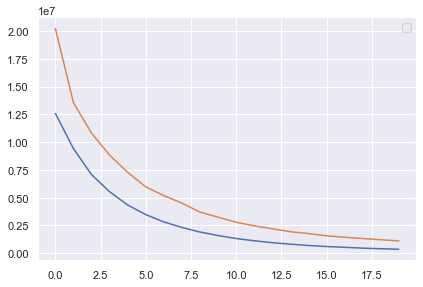

In [139]:
train(network=network, loss_fn=loss_fn, optimizer=optimizer,
      train_loader=train_dl, val_loader=test_dl, n_epochs=20)

## Saving and Loading the Model 

**Saving the whole network**:

To save the current state of the model in [pickle](https://docs.python.org/3/library/pickle.html) format, including the architecture and model weights, use `torch.save()`. This can be loaded at a later time with `torch.load()`. For example,
```python
torch.save(network, "temp/network")
# ... at a later time
network = torch.load("temp/network")
```
- *Note*, saving the architecture and the weights of a model can be problematic if you decide to change the structure of in the future. A better approach would be...

### Saving model weights

- Save the model's (here, that's `network`) `state_dict`, a dictionary that can map to the parameters (weights) in each layer of the model.

In [170]:
system_path = r"C:/Users/uniqu/Adaptation/"
local_path = "temp/saved_weights"
path = system_path + local_path
torch.save(network.state_dict(), path)

Obviously the above file paths will be different for you. I am pleb that uses Windows, so the function throws errors if I don't use the full path instead of the local one. If you need to find out what directory you're in, type `!cd` 
into a jupyter cell and run it.

In [173]:
# ... at a later time
network_state_dict = torch.load(path); network_state_dict

OrderedDict([('fc1.weight',
              tensor([[-0.0507, -0.2248,  0.1273,  0.0251, -0.1203,  0.1695,  0.2443,  0.2051,
                       -0.2454,  0.1476],
                      [ 0.3957, -0.0574, -0.1331, -0.1770,  0.3058, -0.1162,  0.0350,  0.0306,
                        0.2459,  0.0374],
                      [ 0.1601, -0.1376,  0.0851, -0.0617, -0.4338,  0.2878,  0.3386,  0.1304,
                        0.0022, -0.2074],
                      [ 0.2238,  0.3417, -0.0594, -0.1367,  0.2812, -0.1607, -0.0521, -0.2204,
                        0.1757, -0.0055],
                      [ 0.0858, -0.0875, -0.1530, -0.0106, -0.1805, -0.1076, -0.2145, -0.2438,
                       -0.3457, -0.0484],
                      [-0.0563, -0.8017,  0.5809,  0.0538, -0.0139, -0.4515,  0.0967, -0.2560,
                        0.0836, -0.3426],
                      [ 0.0879,  0.2815,  0.0028, -0.1830,  0.2280, -0.0396,  0.1716,  0.2164,
                       -0.1145, -0.0441]])),
          

In [175]:
new_net = Net(); print(new_net)

Net(
  (fc1): Linear(in_features=10, out_features=7, bias=True)
  (fc2): Linear(in_features=7, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)


In [176]:
new_net.load_state_dict(network_state_dict)

<All keys matched successfully>

 One large benefit here is that the you can set the argument `strict = False` in `load_state_dict()` to have the function ignore non-matching keys, which enables you to assign parameters only to layers that *do* exist in the state dictionary and **prevents the load from failing even if the new architecture doesn't match the old one**.
 
This means that you can **load in and use parameters from an entirely different model**. 

## References
- <a id='s0'> </a> UCI Machine Learning Repository. *Facebook Comment Volume Dataset*. https://archive.ics.uci.edu/ml/datasets/Facebook+Comment+Volume+Dataset# 
- <a id='s1'></a>Goodfellow, I., Bengio, Y., Courville, A. (2016). *Deep learning* (Vol. 1). Cambridge: MIT press.
- Lu, Z., Pu, H., Wang, F., Hu, Z., & Wang, L. (2017). *The expressive power of neural networks: A view from the width*. In Advances in neural information processing systems (pp. 6231-6239).
- Brownlee, J. (2019). A gentle introduction to the rectified linear unit (relu). *Machine Learning Mastery. https://machinelearningmastery.com/rectified-linear-activation-function-fordeep-learning-neural-networks*.
- Inkawhich, M. (2017). [*Saving and Loading Models*](https://pytorch.org/tutorials/beginner/saving_loading_models.html#:~:text=save()%20to%20serialize%20the,the%20dictionary%20locally%20using%20torch) . PyTorch Official Docs.


----
## Next Steps:

### Feedback
- Have some beginners in DL go through this tutorial and give feedback.

### Convolutional NN | (Computer Vision) Cat Dog
  - Save a CNN and use it on this dataset. 
  - Explain fundamental CNN concepts. 
  - Data from [Kaggle competition](https://www.kaggle.com/c/dogs-vs-cats/overview)
  - [jaeboklee](https://www.kaggle.com/jaeboklee/pytorch-cat-vs-dog)

### Recurrent NN | Time series or NLP Tutorial